# 查看FashionMNIST原始数据格式

In [17]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from deeplearning_model import EarlyStopping, ModelSaver,train_classification_model,plot_learning_curves
from deeplearning_model import evaluate_classification_model as evaluate_model


In [18]:
import json
token = {"username":"cskaoyan","key":"ff99d9d7ff71704e3e761217ceec03c5"}
with open('/content/kaggle.json', 'w') as file:
  json.dump(token, file)

In [19]:
!cat /content/kaggle.json

{"username": "cskaoyan", "key": "ff99d9d7ff71704e3e761217ceec03c5"}

In [20]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config set -n path -v /content

- path is now set to: /content


In [21]:
!kaggle competitions download -c cifar-10

 94% 673M/715M [00:03<00:00, 50.6MB/s]
100% 715M/715M [00:03<00:00, 195MB/s] 


In [22]:
!unzip /content/competitions/cifar-10/cifar-10.zip

Archive:  /content/competitions/cifar-10/cifar-10.zip
  inflating: sampleSubmission.csv    
  inflating: test.7z                 
  inflating: train.7z                
  inflating: trainLabels.csv         


In [23]:
# !pip install py7zr
import py7zr
a =py7zr.SevenZipFile(r'./train.7z','r')
a.extractall(path=r'./competitions/cifar-10/')
a.close()

In [25]:
!ls competitions/cifar-10/train|wc -l

50000


# 加载数据并处理为tensor

In [1]:
import torch
import torchvision.models as models
from torch.autograd import Variable
# 加载预训练的ResNet18模型
resnet18 = models.resnet18(pretrained=True)  # 加载带有ImageNet预训练权重的ResNet18

# 打印模型结构
print(resnet18)  # 输出模型结构信息

# 查看模型的层级结构
for name, module in resnet18.named_children():
    print(f"{name}: {module}")  # 打印每一层的名称和结构

# 中文注释：
# 1. 加载了torchvision自带的ResNet18模型，并使用了预训练权重（ImageNet）。
# 2. print(resnet18)可以查看整个模型的结构和参数分布。
# 3. 通过遍历named_children()，可以详细查看每一层的名称和对应的子模块结构，便于理解模型的组成。


d:\python\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\python\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\hsl/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:07<00:00, 6.68MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [3]:
from torchviz import make_dot
from PIL import Image
from torchsummary import summary
# 创建一个示例输入
x = Variable(torch.randn(1, 3, 224, 224))

# 获取模型输出
y = resnet18(x)

# 创建模型结构可视化图
#model_graph = make_dot(y, params=dict(list(resnet18.named_parameters())))

# 保存图像
#model_graph.render("resnet18_structure", format="png", cleanup=True)

print("模型结构图已保存为 'resnet18_structure.png'")

# 显示模型结构图
try:
    img = Image.open("resnet18_structure.png")
    plt.figure(figsize=(15, 20))
    plt.imshow(np.array(img))
    plt.axis('off')
    plt.title("resnet18模型结构图")
    plt.show()
except:
    print("无法显示图像，请检查torchviz是否正确安装")

# 使用torchsummary打印模型的详细参数信息
print("resnet18模型的详细参数信息:")
summary(resnet18, (3, 224, 224), device="cpu")

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [26]:
# 加载CIFAR-10数据集
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset

# 定义CIFAR-10数据集类
class CIFAR10Dataset(Dataset):
    def __init__(self, img_dir, labels_file, transform=None):
        self.img_dir = img_dir
        self.transform = transform

        # 读取标签文件，read_csv默认读取第一行作为列名
        self.labels_df = pd.read_csv(labels_file)
        self.img_names = self.labels_df.iloc[:, 0].values.astype(str)  # 第一列是图片名称，确保为字符串类型

        # 类别名称字典，使用字典可以提高查找速度
        self.class_names_dict = {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3,
                                 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
        # 将文本标签转换为数字ID
        self.labels = [self.class_names_dict[label] for label in self.labels_df.iloc[:, 1].values]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx): #getitem方法来获取图片张量数据和标签
        img_path = os.path.join(self.img_dir, self.img_names[idx] + '.png') #图片路径
        image = Image.open(img_path) #打开图片
        label = self.labels[idx]

        if self.transform:
            image_tensor = self.transform(image)

        return image_tensor, label #返回图片和标签

# 定义数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4917, 0.4826, 0.4471), (0.2023, 0.1994, 0.2010))
])

# 加载CIFAR-10数据集
img_dir = r"competitions/cifar-10/train"
labels_file = r"./trainLabels.csv"
full_dataset = CIFAR10Dataset(img_dir=img_dir, labels_file=labels_file, transform=transform)

# 定义类别名称
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 划分训练集和验证集
train_size = 45000
val_size = 5000
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset,
    [train_size, val_size],
    generator=generator
)

# 查看数据集基本信息
print(f"完整数据集大小: {len(full_dataset)}")
print(f"训练集大小: {len(train_dataset)}")
print(f"验证集大小: {len(val_dataset)}")


完整数据集大小: 50000
训练集大小: 40000
验证集大小: 10000


In [27]:
def cal_mean_std(ds):
    mean = 0.
    std = 0.
    for img, _ in ds:
        mean += img.mean(dim=(1, 2)) #dim=(1, 2)表示在通道维度上求平均
        std += img.std(dim=(1, 2))  #dim=(1, 2)表示在通道维度上求标准差
    mean /= len(ds)
    std /= len(ds)
    return mean, std
# cal_mean_std(train_dataset)

(tensor([0.4917, 0.4826, 0.4471]), tensor([0.2023, 0.1994, 0.2010]))

# 把数据集划分为训练集40000和验证集10000，并给DataLoader

In [28]:

# 创建数据加载器
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True #打乱数据集，每次迭代时，数据集的顺序都会被打乱
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False
)




# 搭建模型

In [29]:
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    """
    ResNet18的基本残差块
    """
    expansion = 1  # 残差块输出通道扩展倍数

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        """
        参数:
            in_channels: 输入通道数
            out_channels: 输出通道数
            stride: 步幅
            downsample: 下采样层（用于匹配维度）
        """
        super().__init__()
        # 第一个卷积层
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        # 第二个卷积层
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        # 如果输入和输出通道数不同或步长不为1，则需要使用1x1卷积进行调整
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

       #下采样层指示是否需要下采样，即卷积核大小为3x3，步长为2，填充为1
       # 与self.shortcut类似,显示结构的下采样层逻辑，这种设计允许更灵活地定制残差连接，特别是在构建复杂网络架构（如 ResNet 变体）时
        self.downsample = downsample  # 下采样层（如果需要调整维度），自定义在卷积块中进行下采样
       #downsample = nn.Sequential(nn.Conv2d(64, 128, kernel_size=1, stride=2, bias=False),nn.BatchNorm2d(128))

    def forward(self, x):
        """
        前向传播
        """
        # identity即residual
        identity = x  # 保存输入用于残差连接

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)  # 第一次激活

        out = self.conv2(out)
        out = self.bn2(out)
        # 如果需要下采样，则对identity进行下采样
        #if self.downsample is not None:identity = self.downsample(x)
        out += self.shortcut(identity)  # 残差连接
        out = self.relu(out)  # 第二次激活

        return out


class Resnet18Network(nn.Module):
    def __init__(self, activation='relu',num_classes=10):
        """
        参数:
            activation: 激活函数类型，默认为'relu'，可选'selu'
        """
        super().__init__()#

        # 选择激活函数
        if activation.lower() == 'selu':
            act_layer = nn.SELU  # SELU激活
        else:
            act_layer = nn.ReLU  # 默认ReLU激活

        # 第一组卷积层 - 使用Sequential组织
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # 输入通道3，输出通道128，卷积核3x3，padding=1
            nn.BatchNorm2d(64),
            act_layer(),
            nn.MaxPool2d(kernel_size=2, stride=2)         # 最大池化，尺寸减半
        )
        # 定义残差层和全局平均池化和全连接层
        # 第二组卷积块：包含2个残差块，输入通道64，输出通道128
        self.conv_block2 = nn.Sequential(
            BasicBlock(64, 64, stride=2),  # 第一个残差块，下采样
            BasicBlock(64, 64)            # 第二个残差块
        )
        # 第三组卷积块：包含2个残差块，输入通道128，输出通道256
        self.conv_block3 = nn.Sequential(
            BasicBlock(64, 128, stride=2),  # 第一个残差块，下采样
            BasicBlock(128, 128)             # 第二个残差块
        )

        # 第四组卷积块：包含2个残差块，输入通道256，输出通道512
        self.conv_block4 = nn.Sequential(
            BasicBlock(128, 256, stride=2),  # 第一个残差块，下采样
            BasicBlock(256, 256)             # 第2个残差块
        )

        # 第五组卷积块：包含2个残差块，输入通道256，输出通道512
        self.conv_block4 = nn.Sequential(
            BasicBlock(256, 512, stride=2),  # 第一个残差块，下采样
            BasicBlock(512,512)             # 第2个残差块
        )

        # 全局平均池化层
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # 输出为(batch, 通道, 1, 1)
        
        # 全连接分类器
        self.classifier = nn.Sequential(
            nn.Linear(512, num_classes)  # 512为最后通道数，num_classes默认10为CIFAR-10类别数
        )

        # 中文注释：定义了两组残差块用于特征提取，使用全局平均池化降维，最后通过全连接层输出分类结果

        


    def forward(self, x):
        # 前向传播使用Sequential定义的块
        x = self.conv_block1(x)  # 第一组卷积块
        x = self.conv_block2(x)  # 第二组卷积块
        x = self.conv_block3(x)  # 第三组卷积块
        x = self.conv_block4(x)  # 第四组卷积块

        # 全局平均池化
        x = self.global_avg_pool(x)
        x = torch.flatten(x,1),              # 展平
        # 分类器
        x = self.classifier(x)  # 全连接分类器

        return x  # 输出结果


In [30]:
# 实例化模型
model = Resnet18Network()

# 从train_loader获取第一个批次的数据
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 查看批次数据的形状
print("批次图像形状:", images.shape)
print("批次标签形状:", labels.shape)


print('-'*100)
# 进行前向传播
with torch.no_grad():  # 不需要计算梯度
    outputs = model(images)


print(outputs.shape)


批次图像形状: torch.Size([64, 3, 32, 32])
批次标签形状: torch.Size([64])
----------------------------------------------------------------------------------------------------
torch.Size([64, 10])


In [31]:
# 计算模型的总参数量
# 统计需要求梯度的参数总量
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"需要求梯度的参数总量: {total_params}")

# 统计所有参数总量
all_params = sum(p.numel() for p in model.parameters())
print(f"模型总参数量: {all_params}")

# 查看每层参数量明细
print("\n各层参数量明细:")
for name, param in model.named_parameters():
    print(f"{name}: {param.numel()} 参数")


需要求梯度的参数总量: 13102090
模型总参数量: 13102090

各层参数量明细:
conv_block1.0.weight: 3456 参数
conv_block1.0.bias: 128 参数
conv_block1.1.weight: 128 参数
conv_block1.1.bias: 128 参数
conv_block1.3.weight: 147456 参数
conv_block1.3.bias: 128 参数
conv_block1.4.weight: 128 参数
conv_block1.4.bias: 128 参数
conv_block2.0.weight: 294912 参数
conv_block2.0.bias: 256 参数
conv_block2.1.weight: 256 参数
conv_block2.1.bias: 256 参数
conv_block2.3.weight: 589824 参数
conv_block2.3.bias: 256 参数
conv_block2.4.weight: 256 参数
conv_block2.4.bias: 256 参数
conv_block3.0.weight: 1179648 参数
conv_block3.0.bias: 512 参数
conv_block3.1.weight: 512 参数
conv_block3.1.bias: 512 参数
conv_block3.3.weight: 2359296 参数
conv_block3.3.bias: 512 参数
conv_block3.4.weight: 512 参数
conv_block3.4.bias: 512 参数
classifier.0.weight: 8388608 参数
classifier.0.bias: 1024 参数
classifier.3.weight: 131072 参数
classifier.3.bias: 128 参数
classifier.5.weight: 1280 参数
classifier.5.bias: 10 参数


# 设置交叉熵损失函数，SGD优化器

In [34]:
# 定义损失函数和优化器
from torchvision.models import ResNet


loss_fn = nn.CrossEntropyLoss()  # 交叉熵损失函数，适用于多分类问题，里边会做softmax，还有会把0-9标签转换成one-hot编码

model = Resnet18Network()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # SGD优化器，学习率为0.01，动量为0.9

损失函数: CrossEntropyLoss()


In [37]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")
model = model.to(device) #将模型移动到GPU
early_stopping=EarlyStopping(patience=5, delta=0.001)
model_saver=ModelSaver(save_dir='model_weights', save_best_only=True)


model, history = train_classification_model(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs=50, early_stopping=early_stopping, model_saver=model_saver, tensorboard_logger=None)



使用设备: cuda:0
训练开始，共31250步


  0%|          | 0/31250 [00:00<?, ?it/s]

早停触发!
84.8600
早停: 在18000 步


In [38]:
history['val'][-10:-1]

[{'loss': 0.7029102036952972, 'acc': 84.68, 'step': 13500},
 {'loss': 0.7075497475147248, 'acc': 84.59, 'step': 14000},
 {'loss': 0.7089583341121674, 'acc': 84.71, 'step': 14500},
 {'loss': 0.7092348321914673, 'acc': 84.72, 'step': 15000},
 {'loss': 0.7102686545848846, 'acc': 84.86, 'step': 15500},
 {'loss': 0.7113624195575714, 'acc': 84.8, 'step': 16000},
 {'loss': 0.7163639873027802, 'acc': 84.57, 'step': 16500},
 {'loss': 0.7186705581665039, 'acc': 84.76, 'step': 17000},
 {'loss': 0.717527251291275, 'acc': 84.59, 'step': 17500}]

# 绘制损失曲线和准确率曲线

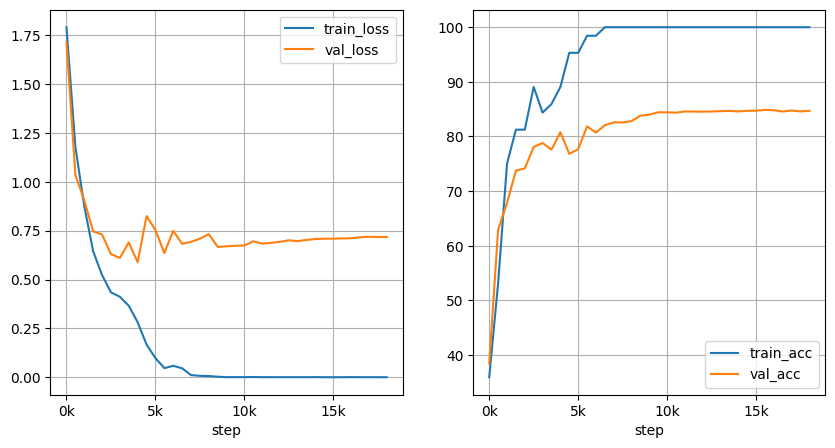

In [39]:
plot_learning_curves(history, sample_step=500)  #横坐标是 steps

In [40]:
a =py7zr.SevenZipFile(r'./test.7z','r')
a.extractall(path=r'./competitions/cifar-10/')
a.close()

In [41]:
!ls competitions/cifar-10/test|wc -l

300000


In [42]:
!ls

competitions	       model_weights  sampleSubmission.csv  trainLabels.csv
deeplearning_model.py  __pycache__    test.7z
kaggle.json	       sample_data    train.7z


In [43]:
# 导入所需库
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import tqdm

# 定义测试数据集类
class CIFAR10TestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        """
        初始化测试数据集

        参数:
            img_dir: 测试图片目录
            transform: 图像预处理变换
        """
        self.img_dir = img_dir
        self.transform = transform
        self.img_files = [f for f in os.listdir(img_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # 提取图像ID（文件名去掉扩展名）
        img_id = int(os.path.splitext(self.img_files[idx])[0])

        return image, img_id

# 定义预测函数
def predict_test_set(model, img_dir, labels_file, device, batch_size=64):
    """
    预测测试集并生成提交文件

    参数:
        model: 训练好的模型
        img_dir: 测试图片目录
        labels_file: 提交模板文件路径
        device: 计算设备
        batch_size: 批处理大小
    """
    # 图像预处理变换（与训练集相同）
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4917, 0.4823, 0.4467), (0.2024, 0.1995, 0.2010))
    ])

    # 创建测试数据集和数据加载器
    test_dataset = CIFAR10TestDataset(img_dir, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    # 设置模型为评估模式
    model.eval()

    # 读取提交模板
    submission_df = pd.read_csv(labels_file)
    predictions = {}

    # 使用tqdm显示进度条
    print("正在预测测试集...")
    with torch.no_grad():
        for images, img_ids in tqdm.tqdm(test_loader, desc="预测进度"):
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1) #取最大的索引，作为预测结果

            # 记录每个图像的预测结果
            for i, img_id in enumerate(img_ids):
                predictions[img_id.item()] = predicted[i].item() #因为一个批次有多个图像，所以需要predicted[i]

    # 定义类别名称
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    # 将数值标签转换为类别名称
    labeled_predictions = {img_id: class_names[pred] for img_id, pred in predictions.items()}

    # 直接创建DataFrame
    submission_df = pd.DataFrame({
        'id': list(labeled_predictions.keys()),
        'label': list(labeled_predictions.values())
    })
    # 按id列排序
    submission_df = submission_df.sort_values(by='id')

    # 检查id列是否有重复值
    has_duplicates = submission_df['id'].duplicated().any()
    print(f"id列是否有重复值: {has_duplicates}")
    # 保存预测结果
    output_file = 'cifar10_submission.csv'
    submission_df.to_csv(output_file, index=False)
    print(f"预测完成，结果已保存至 {output_file}")

# 执行测试集预测
img_dir = r"competitions/cifar-10/test"
labels_file = r"./sampleSubmission.csv"
predict_test_set(model, img_dir, labels_file, device, batch_size=128)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


正在预测测试集...


预测进度:   0%|          | 0/2344 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
预测进度: 100%|██████████| 2344/2344 [01:55<00:00, 20.22it/s]


id列是否有重复值: False
预测完成，结果已保存至 cifar10_submission.csv


In [44]:
!head -10 cifar10_submission.csv

id,label
1,airplane
2,airplane
3,automobile
4,ship
5,airplane
6,cat
7,airplane
8,horse
9,airplane


In [45]:
!wc -l cifar10_submission.csv

300001 cifar10_submission.csv
